In [29]:
# Install ReadVTK with: import Pkg; Pkg.add("ReadVTK")
using ReadVTK

# Loading VTI files into Julia

function read_vti( filename, typ=Float64 )
    
    vtk_file       = VTKFile( filename )
    vtk_cell_data  = get_cell_data(vtk_file)
    vtk_data_array = vtk_cell_data["intensities"]
    data_size, _   = ReadVTK.get_wholeextent(vtk_data_array.vtk_file.xml_file, false)
    vtk_data       = get_data( vtk_data_array ); 
    data_reshaped  = reshape(vtk_data, (data_size .- 1 )...); 
    return typ.( data_reshaped ) 
end


read_vti (generic function with 2 methods)

In [30]:
# Extract the single i-th layer from vti files and save the image data
# over all time points locally into a .h5 file.

using HDF5

function extract_layer(folder_path::String, i::Int64)
    
    # variable folder_path should be in type string.
    #n_files = length(readdir(folder_path))
    
    # Storing data from a single layer over time in an Array. 
    layer_data = Matrix{Float64}[]
    
    for file in readdir(folder_path)
        # file is in type String. Open the file.
        cell_data = read_vti(folder_path * "\\" * file)
        # Choose the i-th layer from the cell data and append it 
        # to layer_data.
        push!(layer_data, cell_data[:,:,i])
    end
    
    # Convert the layer_data to 3D array structure
    # (width, height, timepoint) dimensional.
    l_data = reduce((x,y) -> cat(x,y,dims=3), layer_data)

    # Save the data in .h5 file with package HDF5.jl
    h5open("headon_layer_"*string(i)*".h5", "w") do file
    write(file, "data", l_data)  
    end

end

extract_layer (generic function with 1 method)

In [31]:
# Read h5 file in which image data is saved. 

function read_h5(folder_path::String)
    h5open(folder_path, "r") do file
        read(file, "data")
    end
end


read_h5 (generic function with 1 method)

In [32]:
data_2 = read_h5("headon_layer_2.h5")

1024×1024×11 Array{Float64, 3}:
[:, :, 1] =
   80.0    43.0    81.0    35.0   55.0  …   919.0  1204.0   366.0   329.0
   83.0    51.0    30.0    46.0   34.0      789.0   681.0   204.0  1294.0
  397.0    25.0   292.0   252.0  120.0       29.0    42.0   227.0    42.0
   78.0   922.0    19.0    96.0   84.0      378.0   184.0   620.0    22.0
  618.0   431.0    96.0   259.0  621.0      166.0    63.0   137.0   974.0
 1252.0    51.0  1439.0    48.0   94.0  …   922.0  1077.0    33.0   734.0
  899.0    74.0    30.0   824.0   37.0      284.0   665.0   548.0    58.0
  728.0  1014.0   493.0    70.0   57.0       52.0    51.0   246.0    26.0
   52.0   572.0    42.0   527.0  103.0      116.0   635.0  1025.0  1035.0
  212.0    48.0    34.0   549.0  500.0       34.0    98.0   369.0   190.0
 1280.0   175.0   476.0   614.0  485.0  …   127.0   478.0   585.0   625.0
  469.0   342.0   738.0   877.0   44.0      517.0   965.0   107.0  1213.0
  176.0  2265.0    48.0   527.0  610.0      336.0  1090.0    94.0   

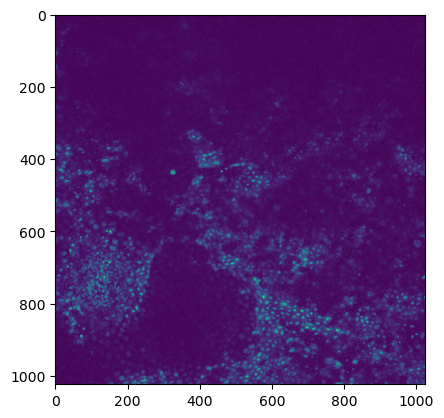

PyObject <matplotlib.image.AxesImage object at 0x000002860584EAD0>

In [33]:
imshow(data_2[:, :, 11])

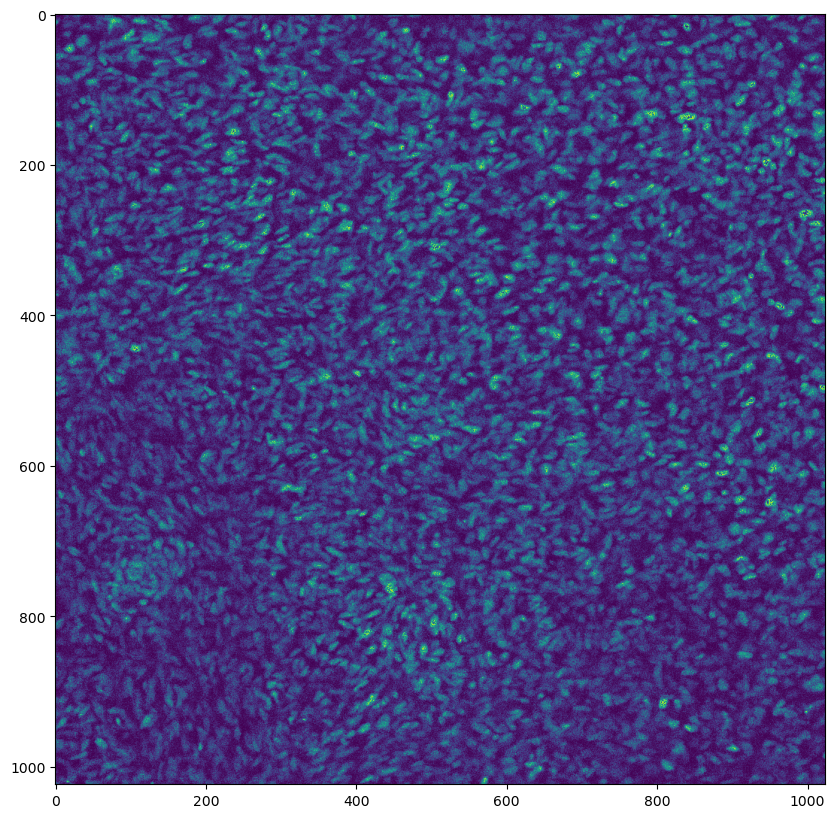

In [34]:
# Function for presenting single layer dynamics over time as .gif

using PyCall
@pyimport matplotlib.animation as anim
using PyPlot

# Update function for video.

# Making video.
#function single_layer_dyn(folder_path::String, filename::String)
    # Read the data saved in .h5 file.
data = read_h5("headon_layer_5.h5")

fig = PyPlot.figure(figsize=(10, 10))

function make_frame(i)
    imshow(data[:, :, i+1])
end

myanim = anim.FuncAnimation(fig, make_frame, frames=size(data, 3), 
                                interval=200, repeat=false, blit=false)
myanim[:save]("headon_layer_5.gif", writer="pillow")
#end

In [35]:
using PyCall
@pyimport matplotlib.animation as anim
using PyPlot

function make_frame(i, data)
    imshow(data[:, :, i+1])
end

function single_layer_dyn(open_filename::String, save_filename::String)
    data = read_h5(open_filename*".h5")
    
    fig = PyPlot.figure(figsize=(10, 10))
    
    myanim = anim.FuncAnimation(fig, make_frame, frames=size(data, 3), 
                                interval=200, repeat=false, blit=false)
    myanim[:save](save_filename*".gif", writer="pillow")
end
    

single_layer_dyn (generic function with 1 method)

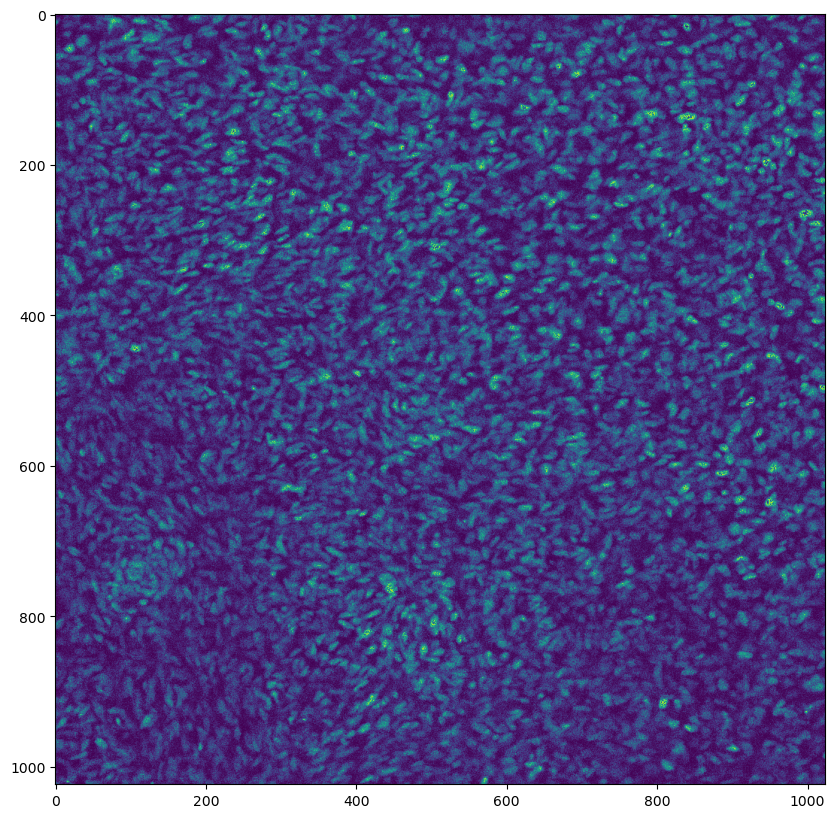

In [36]:
single_layer_dyn("headon_layer_5", "headon_layer_5")

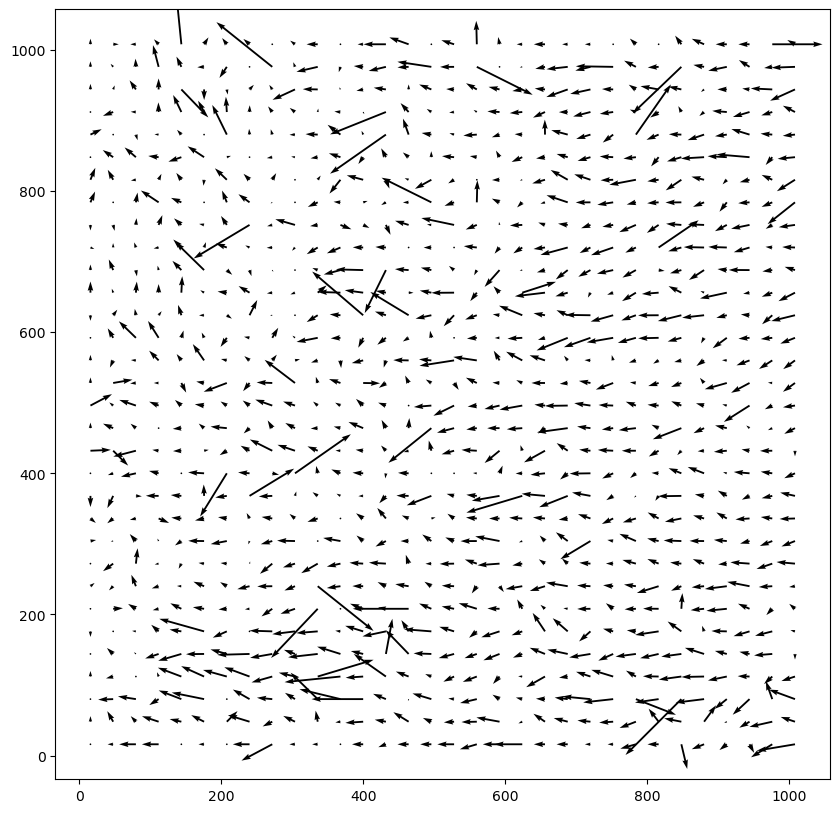

In [41]:
# Function for PIV vector fields. (Causion the orientation y-axis!)

using PyCall
@pyimport matplotlib.animation as anim
using PyPlot
using Images
using multi_quickPIV

l_data = read_h5("headon_layer_5.h5")

default_params = multi_quickPIV.setPIVParameters() 
IA_size = multi_quickPIV._isize( default_params )[1:2]
IA_step = multi_quickPIV._step( default_params )[1:2]

fig = PyPlot.figure(figsize=(10, 10))

function make_frame(i) # Due to Python function i begins with 0!
    
    PyPlot.clf()
    
    img1 = Float64.(Gray.(l_data[:, :, i+1]))
    img2 = Float64.(Gray.(l_data[:, :, i+2]))
    
    VF, SN = multi_quickPIV.PIV(img1, img2)
    
    U = VF[ 1, :, : ]
    V = VF[ 2, :, : ]
    
    xgrid = [ (x-1)*IA_step[2] + div(IA_size[2],2) for y in 1:size(U,1), x in 1:size(U,2) ] 
    ygrid = [ (y-1)*IA_step[1] + div(IA_size[1],2) for y in 1:size(U,1), x in 1:size(U,2) ]
    
    PyPlot.quiver( xgrid, ygrid, V, -1 .* U )
end

myanim = anim.FuncAnimation(fig, make_frame, frames=size(l_data,3)-1, 
                            interval=400)
myanim[:save]("headon_5_piv.gif", writer="pillow")
